In [5]:
############# Mountiong Google Drive and Changing Working Directory PATH to Dataset Directory PATH ##################

from google.colab import drive
drive.mount('/content/drive')

directory_path = "/content/drive/MyDrive/updatedataset"

################# Changing the Working Directory Path ################## 
import os
os.chdir(directory_path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
autoencoder.h5	GoodTray  InitialTrayImages  testfolder


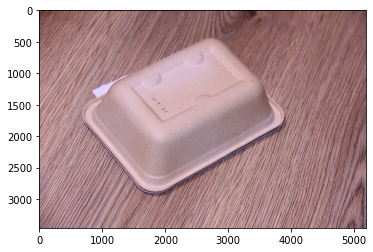

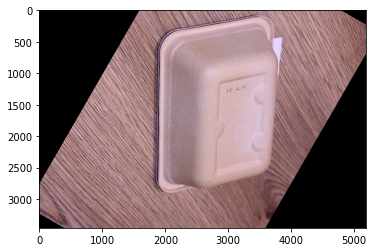

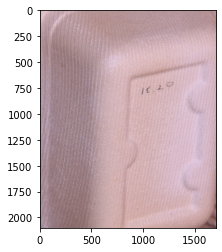

Tray Image Shape: (2100, 1700, 3)


In [6]:
#################### Showing the Process for Cropping the Plate Area from the Dataset Images ##################

import numpy as np
import cv2
from scipy import ndimage
from skimage import io
from skimage.transform import rotate
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.color import rgb2hsv
import glob
import os
from skimage.transform import resize


import os
os.chdir("{}/InitialTrayImages".format(directory_path))


############# Code for Cropping, Rotating and 1 Image ###################
tmp_path = "IMG_7545.JPG" 
tmp_img = io.imread(tmp_path)
plt.imshow(tmp_img)
plt.show()
rotated = ndimage.rotate(tmp_img, -120, reshape=False) ############ Roration Angle for tilted Image 
plt.imshow(rotated)
plt.show()
tray = rotated[500:2600,2000:3700,:] ############ Crop Arae for tilted Image
plt.imshow(tray)  
plt.show()
print("Tray Image Shape:", tray.shape)


Showing the 30 Slices of an cropped Image: 


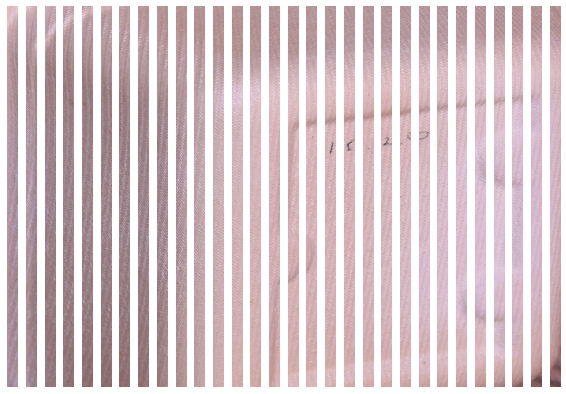

In [7]:
################################ Showing the Process of Dividind Each Cropped Image into 30 Slices to store into New Directory of Good Tray Sliced Data ###################

_ , width, _ = tray.shape
numb_of_sliced_per_image = 30
slice_width = int (width/numb_of_sliced_per_image)

sliced_images_list = []

for i in range(numb_of_sliced_per_image):
  sliced_img = tray [:, slice_width*i:slice_width*(i+1), :]
  sliced_images_list.append(sliced_img)

print("Showing the 30 Slices of an cropped Image: ")
fig = plt.figure(figsize=(10, 7))
for i, tmp_sliced in enumerate(sliced_images_list, 1 ):
  fig.add_subplot(1, numb_of_sliced_per_image , i)
  plt.imshow(tmp_sliced)
  plt.axis('off')
plt.show()





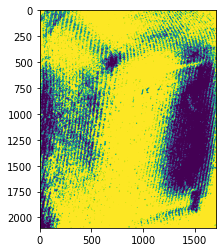

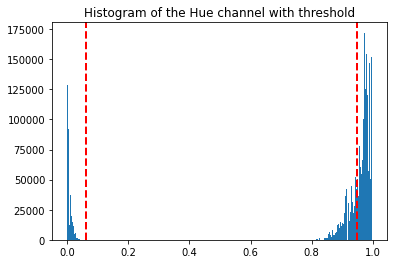

(2100, 1700, 3)


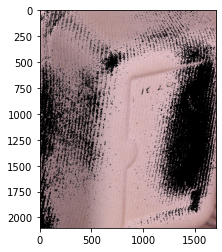

In [8]:
###################### Showing Pre-Processing of Image and Coverting into HSV format to find Faulty Area on the Tray ##############

I = rgb2hsv(tray)
hue_img = I[:, :, 0]

# Define thresholds for channel 1 based on histogram settings
channel1Min = 0.95
channel1Max = 0.06
# Define thresholds for channel 2 based on histogram settings
channel2Min = 0.000
channel2Max = 1.000
# Define thresholds for channel 3 based on histogram settings
channel3Min = 0.000
channel3Max = 1.000
sliderBW = ( (I[:,:,0] >= channel1Min) | (I[:,:,0] <= channel1Max) ) & (I[:,:,1] >= channel2Min ) & (I[:,:,1] <= channel2Max) & (I[:,:,2] >= channel3Min ) & (I[:,:,2] <= channel3Max)
plt.imshow(sliderBW)
plt.show()

plt.hist(hue_img.ravel(), 512)
plt.title("Histogram of the Hue channel with threshold")
plt.axvline(x=channel1Min, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=channel1Max, color='r', linestyle='dashed', linewidth=2)
plt.show()

maskedRGBImage = tray.copy()

BW = sliderBW
maskedRGBImage = tray.copy()
print(maskedRGBImage.shape)
WB= ~BW
WB = WB.reshape(WB.shape[0],WB.shape[1],1)
tile= np.repeat(WB, [3], axis=-1)
maskedRGBImage[tile] = 0

plt.imshow(maskedRGBImage)
plt.show()

################ Black Area Shows the Faulty Part of the Image ###########################


In [9]:
#################### Making a Numpy Array from Stored sliced images to train the network ####################

import numpy as np
import cv2
from scipy import ndimage
from skimage import io
from skimage.transform import rotate
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.color import rgb2hsv
import glob
import os
from skimage.transform import resize

all_sliced_images_directory_path = "{}/GoodTray".format(directory_path)
all_sliced_images_paths = glob.glob('{}/*.jpg'.format(all_sliced_images_directory_path) )
print(len(all_sliced_images_paths))


sliced_images_array_data = np.zeros((len(all_sliced_images_paths), 512,64,3))

for i, tmp_img_path in enumerate(all_sliced_images_paths):

  print("Adding {} Sliced Image to Numpy Array".format ( os.path.basename(tmp_img_path)) )
  try:
    tmp_img = io.imread(tmp_img_path)
  except:
    continue

  tmp_img_resized = resize(tmp_img, (512,64,3))

  sliced_images_array_data[i,] = tmp_img_resized



1319
Adding IMG_1 (1).jpg Sliced Image to Numpy Array
Adding IMG_1 (10).jpg Sliced Image to Numpy Array
Adding IMG_1 (100).jpg Sliced Image to Numpy Array
Adding IMG_1 (1000).jpg Sliced Image to Numpy Array
Adding IMG_1 (1001).jpg Sliced Image to Numpy Array
Adding IMG_1 (1002).jpg Sliced Image to Numpy Array
Adding IMG_1 (1004).jpg Sliced Image to Numpy Array
Adding IMG_1 (1005).jpg Sliced Image to Numpy Array
Adding IMG_1 (1007).jpg Sliced Image to Numpy Array
Adding IMG_1 (1008).jpg Sliced Image to Numpy Array
Adding IMG_1 (1009).jpg Sliced Image to Numpy Array
Adding IMG_1 (101).jpg Sliced Image to Numpy Array
Adding IMG_1 (1010).jpg Sliced Image to Numpy Array
Adding IMG_1 (1011).jpg Sliced Image to Numpy Array
Adding IMG_1 (1012).jpg Sliced Image to Numpy Array
Adding IMG_1 (1013).jpg Sliced Image to Numpy Array
Adding IMG_1 (1014).jpg Sliced Image to Numpy Array
Adding IMG_1 (1015).jpg Sliced Image to Numpy Array
Adding IMG_1 (1016).jpg Sliced Image to Numpy Array
Adding IMG_1 (

In [10]:
##################### Defining Auto-Encoder Architecture ###################################

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

input = layers.Input(shape=(512, 64, 3))

################## Making U-Net Like Covolutional Auto-Encoder Architecture ###################

###### Defining Encoder Model Architecture ################ 
down_Sampling_Stage_1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x1 = layers.MaxPooling2D((2, 2), padding="same")(down_Sampling_Stage_1)
x2 = layers.BatchNormalization()(x1)
down_Sampling_Stage_2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x2)
x3 = layers.MaxPooling2D((2, 2), padding="same")(down_Sampling_Stage_2)
x4 = layers.BatchNormalization()(x3)
down_Sampling_Stage_3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x4)
x5 = layers.MaxPooling2D((2, 2), padding="same")(down_Sampling_Stage_3)
x6 = layers.BatchNormalization()(x5)
down_Sampling_Stage_4 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x6)
x7 = layers.MaxPooling2D((2, 2), padding="same")(down_Sampling_Stage_4)
x8 = layers.BatchNormalization()(x7)
down_Sampling_Stage_5 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x8)
x9 = layers.MaxPooling2D((2, 2), padding="same")(down_Sampling_Stage_5)
x10 = layers.BatchNormalization()(x9)
down_Sampling_Stage_6 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(x10)
x11 = layers.MaxPooling2D((2, 2), padding="same")(down_Sampling_Stage_6)

###### Defining Decoder Model Architecture ################ 
x12 = layers.Conv2DTranspose(1024, (3, 3), strides=2, activation="relu", padding="same")(x11)
x13 = layers.BatchNormalization()(x12)
x14 = layers.Concatenate()([x13, down_Sampling_Stage_6])
x15 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x14)
x16 = layers.BatchNormalization()(x15)
x17 = layers.Concatenate()([x16, down_Sampling_Stage_5])
x18 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x17)
x19 = layers.BatchNormalization()(x18)
x20 = layers.Concatenate()([x19, down_Sampling_Stage_4])
x21 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x20)
x22 = layers.BatchNormalization()(x21)
x23 = layers.Concatenate()([x22, down_Sampling_Stage_3])
x24 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x23)
x25 = layers.BatchNormalization()(x24)
x26 = layers.Concatenate()([x25, down_Sampling_Stage_2])
x27 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x26)
x28 = layers.BatchNormalization()(x27)
x29 = layers.Concatenate()([x28, down_Sampling_Stage_1])
x30 = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x29)

# Autoencoder
autoencoder = Model(input, x30)
autoencoder.compile(optimizer="adam", loss="mse")
print("Showing Auto-Encoder Model Architecture: ")
print(autoencoder.summary())


Showing Auto-Encoder Model Architecture: 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 512, 64, 32)  896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 32, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 32, 32)

Epoch 1/10
442/442 - 53s - loss: 0.0036 - val_loss: 0.0027 - 53s/epoch - 120ms/step
Epoch 2/10
442/442 - 40s - loss: 0.0023 - val_loss: 0.0021 - 40s/epoch - 91ms/step
Epoch 3/10
442/442 - 40s - loss: 0.0016 - val_loss: 0.0029 - 40s/epoch - 91ms/step
Epoch 4/10
442/442 - 40s - loss: 6.5655e-04 - val_loss: 2.5787e-04 - 40s/epoch - 91ms/step
Epoch 5/10
442/442 - 41s - loss: 3.1867e-04 - val_loss: 1.7960e-04 - 41s/epoch - 92ms/step
Epoch 6/10
442/442 - 40s - loss: 2.1791e-04 - val_loss: 2.2862e-04 - 40s/epoch - 91ms/step
Epoch 7/10
442/442 - 40s - loss: 1.8563e-04 - val_loss: 1.7839e-04 - 40s/epoch - 91ms/step
Epoch 8/10
442/442 - 41s - loss: 1.4804e-04 - val_loss: 1.0788e-04 - 41s/epoch - 93ms/step
Epoch 9/10
442/442 - 41s - loss: 1.1357e-04 - val_loss: 7.4731e-05 - 41s/epoch - 92ms/step
Epoch 10/10
442/442 - 40s - loss: 1.0678e-04 - val_loss: 9.7846e-05 - 40s/epoch - 91ms/step
Saving Autoencoder Model for Later Use..
Autoencoder Model Saved.
Showing Training and Validation Losses Graph:


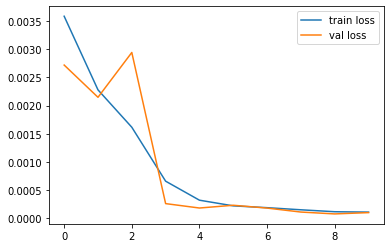

In [11]:
##################### Training Auto-Encoder Model with Given Dataset Images ############################

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(sliced_images_array_data, sliced_images_array_data, test_size=0.33, random_state=42)

history = autoencoder.fit(X_train,y_train,
                          epochs=10, batch_size=2,
                          validation_data=(X_test, y_test),
                          verbose = 2)

model_path = "{}/autoencoder.h5".format(directory_path)
print("Saving Autoencoder Model for Later Use..")
autoencoder.save(model_path)
print("Autoencoder Model Saved.")


print("Showing Training and Validation Losses Graph:")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()



In [17]:
################## Findind Test Accuracy on testfolder Sliced Images ###############
import keras 
import tensorflow as tf

os.chdir( "{}/testfolder".format(directory_path) )
print("Showing Test Folder Images Names: ")
!ls

################### Loading Stored Auto-Encoder Model #########################
model_path = "{}/autoencoder.h5".format(directory_path)
autoencoder = keras.models.load_model(model_path)

testfolder_directory = "{}/testfolder".format(directory_path)
all_sliced_images_paths = glob.glob('{}/*.jpg'.format(testfolder_directory) )

test_img_sliced_array = np.zeros((len(all_sliced_images_paths),512,64,3))

for i, tmp_path in enumerate(all_sliced_images_paths):

  img = io.imread(tmp_path)
  img_resized = resize(img, (512,64,3))

  test_img_sliced_array[i] = img_resized


########## Getting Predictions from trained Auto-Encoder Model ######################
one_pic_output = autoencoder.predict(test_img_sliced_array)

############# Fiding the loss Bet
mse_loses= tf.keras.metrics.mean_squared_error(test_img_sliced_array, one_pic_output)
print(mse_loses.shape)
mse_loses= tf.reduce_sum(mse_loses, axis=-1)
mse_loses= tf.reduce_sum(mse_loses, axis=-1)
print("Individual Losses of 30 Slices Between Actual Slice Image and Auto-encoder Predicted Slice Image: ", mse_loses)

mse_loss_threshod = 100

predicted_class = mse_loses >= mse_loss_threshod

print("Mean Square Loses greater than threshold are considered as faulty slices. Threshold Lose Value is: ", mse_loss_threshod )
actual_test_labels_dictionary = {'IMG_7532_1.jpg': 0, 'IMG_7532_2.jpg': 0, 'IMG_7532_3.jpg': 0, 'IMG_7532_4.jpg': 0, 'IMG_7532_5.jpg': 0, 'IMG_7532_6.jpg': 0,
                                 'IMG_7532_7.jpg': 0, 'IMG_7532_8.jpg': 0, 'IMG_7532_9.jpg': 0, 'IMG_7532_10.jpg': 0, 'IMG_7532_11.jpg': 0, 'IMG_7532_12.jpg': 0,
                                 'IMG_7532_13.jpg': 0, 'IMG_7532_14.jpg': 0, 'IMG_7532_15.jpg': 0, 'IMG_7532_16.jpg': 0, 'IMG_7532_17.jpg': 0, 'IMG_7532_18.jpg': 0,
                                 'IMG_7532_19.jpg': 0, 'IMG_7532_20.jpg': 0, 'IMG_7532_21.jpg': 0, 'IMG_7532_22.jpg': 0, 'IMG_7532_23.jpg': 0, 'IMG_7532_24.jpg': 0,
                                 'IMG_7532_25.jpg': 0, 'IMG_7532_26.jpg': 0, 'IMG_7532_27.jpg': 0, 'IMG_7532_28.jpg': 0, 'IMG_7532_29.jpg': 0, 'IMG_7532_30.jpg': 0,
                                 'IMG_7545_1.jpg': 1, 'IMG_7545_2.jpg': 1, 'IMG_7545_3.jpg': 1, 'IMG_7545_4.jpg': 1, 'IMG_7545_5.jpg': 1, 'IMG_7545_6.jpg': 1,
                                 'IMG_7545_7.jpg': 1, 'IMG_7545_8.jpg': 1, 'IMG_7545_9.jpg': 1, 'IMG_7545_10.jpg': 1, 'IMG_7545_11.jpg': 1 , 'IMG_7545_12.jpg': 1,
                                 'IMG_7545_13.jpg': 1, 'IMG_7545_14.jpg': 1, 'IMG_7545_15.jpg': 1, 'IMG_7545_16.jpg': 1, 'IMG_7545_17.jpg': 1, 'IMG_7545_18.jpg': 1,
                                 'IMG_7545_19.jpg': 1, 'IMG_7545_20.jpg': 1, 'IMG_7545_21.jpg': 1, 'IMG_7545_22.jpg': 1, 'IMG_7545_23.jpg': 1, 'IMG_7545_24.jpg': 1,
                                 'IMG_7545_25.jpg': 1, 'IMG_7545_26.jpg': 1, 'IMG_7545_27.jpg': 1, 'IMG_7545_28.jpg': 1, 'IMG_7545_29.jpg': 1, 'IMG_7545_30.jpg': 1,     
                                 }
actual_test_labels = []

for tmp_path in all_sliced_images_paths:
  tmp_img_name = os.path.basename(tmp_path)
  tmp_label = actual_test_labels_dictionary[tmp_img_name]
  actual_test_labels.append(tmp_label)

from sklearn.metrics import accuracy_score

model_accuracy = accuracy_score(actual_test_labels, predicted_class)
print("Auto-Encoder Model Accuracy on Test Images is : ", model_accuracy, " OR ", model_accuracy*100, "%" )



Showing Test Folder Images Names: 
IMG_7532_10.jpg  IMG_7532_24.jpg  IMG_7545_10.jpg  IMG_7545_24.jpg
IMG_7532_11.jpg  IMG_7532_25.jpg  IMG_7545_11.jpg  IMG_7545_25.jpg
IMG_7532_12.jpg  IMG_7532_26.jpg  IMG_7545_12.jpg  IMG_7545_26.jpg
IMG_7532_13.jpg  IMG_7532_27.jpg  IMG_7545_13.jpg  IMG_7545_27.jpg
IMG_7532_14.jpg  IMG_7532_28.jpg  IMG_7545_14.jpg  IMG_7545_28.jpg
IMG_7532_15.jpg  IMG_7532_29.jpg  IMG_7545_15.jpg  IMG_7545_29.jpg
IMG_7532_16.jpg  IMG_7532_2.jpg   IMG_7545_16.jpg  IMG_7545_2.jpg
IMG_7532_17.jpg  IMG_7532_30.jpg  IMG_7545_17.jpg  IMG_7545_30.jpg
IMG_7532_18.jpg  IMG_7532_3.jpg   IMG_7545_18.jpg  IMG_7545_3.jpg
IMG_7532_19.jpg  IMG_7532_4.jpg   IMG_7545_19.jpg  IMG_7545_4.jpg
IMG_7532_1.jpg	 IMG_7532_5.jpg   IMG_7545_1.jpg   IMG_7545_5.jpg
IMG_7532_20.jpg  IMG_7532_6.jpg   IMG_7545_20.jpg  IMG_7545_6.jpg
IMG_7532_21.jpg  IMG_7532_7.jpg   IMG_7545_21.jpg  IMG_7545_7.jpg
IMG_7532_22.jpg  IMG_7532_8.jpg   IMG_7545_22.jpg  IMG_7545_8.jpg
IMG_7532_23.jpg  IMG_7532_9.jpg   I

Total Number of Test Images are :  60


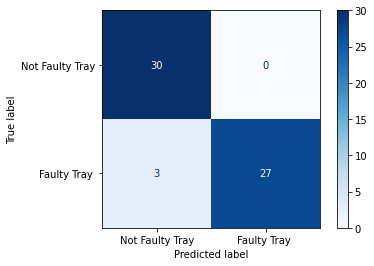

In [18]:
####################### Showing Visualizations of Confusion Matrix ########################
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("Total Number of Test Images are : ", len(actual_test_labels))
labels = ["Not Faulty Tray", "Faulty Tray "]

cm = confusion_matrix(actual_test_labels, predicted_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()
